# Evaluation and Final Model

Evaluating all models to pick the best preforming model.

1. Data
2. Evaluation
3. Feature Importance
4. Checking for Overfitting and Underfitting
5. Final Model

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from pandas.api.types import CategoricalDtype
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
import shap
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import display
import time, gc, json, psutil
import xgboost as xgb
from model_functions import (
    get_generic_preprocessor,
    merge_by_sk_id_curr,
    evaluate_model,
    extract_feature_names,
)
from final_model_functions import (
    merge_by_sk_id_curr,
    FeatureEngineeringTransformer,
    get_generic_preprocessor,
    feature_engineering_custom,
)
import joblib
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Data

In [2]:
application_data = pd.read_csv("application_train.csv")

In [3]:
model_data = merge_by_sk_id_curr(application_data)

In [4]:
X = model_data.drop(columns=["target"])
y = model_data["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 2. Evaluation

### 2.1. Pipeline

Best Parameters:
* XGBoost: max_depth: 5, min_child_weight: 10, n_estimators: 298, learning_rate: 0.05113596608549376, subsample: 0.7482944515367064, colsample_bytree: 0.8021429739691673, max_delta_step: 10.
* LightGBM: max_depth: 6, n_estimators: 146, learning_rate: 0.06854658462312682, num_leaves: 36, min_child_samples: 49, subsample: 0.9551128155998938, colsample_bytree: 0.8916958625383079.
* CatBoost: depth: 5, iterations: 283, learning_rate: 0.09859326359218393, l2_leaf_reg: 3.6492842109610466, border_count: 74

In [5]:
feature_engineering = FeatureEngineeringTransformer(feature_engineering_custom)

feature_engineering.fit(X_train)
X_train_transformed = feature_engineering.transform(X_train)

preprocessor_no_impute = get_generic_preprocessor(X_train_transformed, impute=False)

class_ratio = y_train.value_counts(normalize=True)
scale_pos_weight = (
    class_ratio[0] / class_ratio[1]
    if len(class_ratio) > 1 and class_ratio[1] > 0
    else 1
)

models = {
    "XGBoost": Pipeline(
        [
            ("feature_engineering", feature_engineering),
            ("preprocessor", preprocessor_no_impute),
            (
                "classifier",
                XGBClassifier(
                    max_depth=5,
                    min_child_weight=10,
                    n_estimators=298,
                    learning_rate=0.05113596608549376,
                    subsample=0.7482944515367064,
                    colsample_bytree=0.8021429739691673,
                    max_delta_step=10,
                    random_state=42,
                    scale_pos_weight=scale_pos_weight,
                    use_label_encoder=False,
                    eval_metric="logloss",
                ),
            ),
        ]
    ),
    "LightGBM": Pipeline(
        [
            ("feature_engineering", feature_engineering),
            ("preprocessor", preprocessor_no_impute),
            (
                "classifier",
                LGBMClassifier(
                    max_depth=6,
                    n_estimators=146,
                    learning_rate=0.06854658462312682,
                    num_leaves=36,
                    min_child_samples=49,
                    subsample=0.9551128155998938,
                    colsample_bytree=0.8916958625383079,
                    random_state=42,
                    scale_pos_weight=scale_pos_weight,
                    verbose=-1,
                ),
            ),
        ]
    ),
    "CatBoost": Pipeline(
        [
            ("feature_engineering", feature_engineering),
            ("preprocessor", preprocessor_no_impute),
            (
                "classifier",
                CatBoostClassifier(
                    depth=5,
                    iterations=283,
                    learning_rate=0.09859326359218393,
                    l2_leaf_reg=3.6492842109610466,
                    border_count=74,
                    random_seed=42,
                    auto_class_weights="Balanced",
                    verbose=0,
                ),
            ),
        ]
    ),
}

### 2.2. Evaluation Results

#### XGBoost

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:41:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC AUC: 0.7693
Classification Report for Model:

              precision    recall  f1-score   support

           0       0.96      0.73      0.83     56538
           1       0.18      0.67      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503



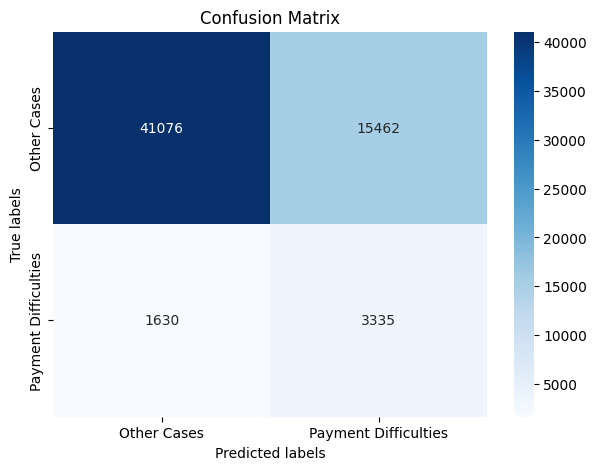

In [6]:
models["XGBoost"].fit(X_train, y_train)
xgboost_prediction = models["XGBoost"].predict(X_val)
evaluate_model(models["XGBoost"], X_val, y_val)

* ROC AUC - 0.7693

Classification report:
* Payment Difficulties: precision (18%), recall (67%), f1-score (28%).
* Other Cases: precision (96%), recall (73%), f1-score (83%).
* Accuracy 72%.

Confusion Matrix:
* Payment Difficulties: correctly predicted 3 335 and wrongly predicted 1 630, almost 32.83% wrongly predicted.
* Other Cases: correctly predicted 41 076 and wrongly predicted 15 462, 27.35% wrongly predicted.

#### LightGBM

C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\japer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ROC AUC: 0.7685
Classification Report for Model:

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56538
           1       0.18      0.68      0.28      4965

    accuracy                           0.72     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.72      0.78     61503



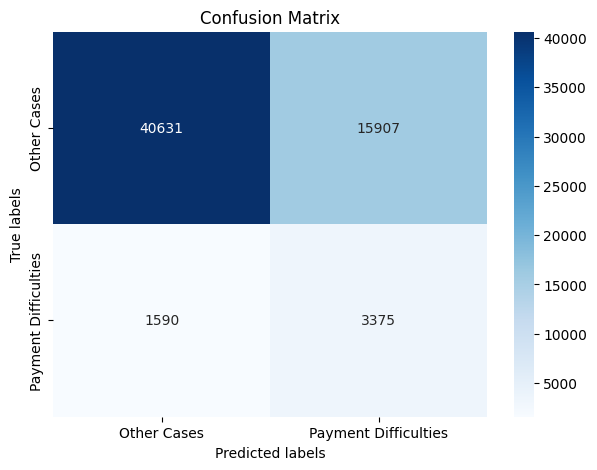

In [7]:
models["LightGBM"].fit(X_train, y_train)
lgbm_prediction = models["LightGBM"].predict(X_val)
evaluate_model(models["LightGBM"], X_val, y_val)

* ROC AUC - 0.7685

Classification report:
* Payment Difficulties: precision (18%), recall (68%), f1-score (28%).
* Other Cases: precision (96%), recall (72%), f1-score (82%).
* Accuracy 72%.

Confusion Matrix:
* Payment Difficulties: correctly predicted 3 375 and wrongly predicted 1 590, 33.87% wrongly predicted.
* Other Cases: correctly predicted 40 631 and wrongly predicted 15 907, 28.14% wrongly predicted.

#### CatBoost

ROC AUC: 0.7698
Classification Report for Model:

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.68      0.28      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503



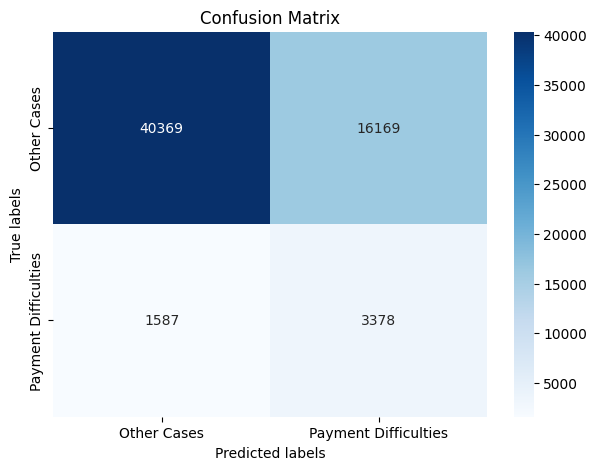

In [8]:
models["CatBoost"].fit(X_train, y_train)
catboost_prediction = models["CatBoost"].predict(X_val)
evaluate_model(models["CatBoost"], X_val, y_val)

* ROC AUC - 0.7698

Classification report:
* Payment Difficulties: precision (17%), recall (68%), f1-score (28%).
* Other Cases: precision (96%), recall (71%), f1-score (82%).
* Accuracy 71%.

Confusion Matrix:
* Payment Difficulties: correctly predicted 3 378 and wrongly predicted 1 587, 31.96% wrongly predicted.
* Other Cases: correctly predicted 40 369 and wrongly predicted 16 169, 28.60% wrongly predicted.

Conclusion:
* All models demonstrated similar ROC AUC scores around 0.77 (XGBoost: 0.7693, LightGBM: 0.7685, CatBoost: 0.7698), indicating comparable overall performance in distinguishing between the classes.
* CatBoost and LightGBM achieved the highest recall (68%) for the minority class (Payment Difficulties), closely followed by XGBoost (67%), showing strong capability in identifying true positive cases.
* CatBoost had the lowest false negative rate for Payment Difficulties (31.96% misclassified), with XGBoost (32.83%) and LightGBM (33.87%) slightly higher.
* XGBoost achieved the highest accuracy (72%) and the lowest error rate when predicting Other Cases (27.35% misclassified), while CatBoost showed slightly lower accuracy (71%).

Model Selected CatBoost for its consistent and balanced performance: it achieved the highest recall for the minority class with the lowest false negative rate, while maintaining strong overall accuracy and precision, making it a dependable model for predicting payment difficulties.

## 3. Feature Importance

In [9]:
feature_engineering = models["CatBoost"].named_steps["feature_engineering"]
preprocessor = models["CatBoost"].named_steps["preprocessor"]
catboost_model = models["CatBoost"].named_steps["classifier"]

X_fe_train = feature_engineering.transform(X_train)
if isinstance(X_fe_train, pd.DataFrame):
    fe_feature_names = X_fe_train.columns.tolist()
else:
    fe_feature_names = [f"feature_{i}" for i in range(X_fe_train.shape[1])]

real_feature_names = extract_feature_names(preprocessor, fe_feature_names)

X_train_transformed = preprocessor.transform(X_fe_train)
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

if len(real_feature_names) != X_train_transformed.shape[1]:
    real_feature_names = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]

explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_train_transformed)

shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame(
    {"Feature": real_feature_names, "Importance": shap_importance}
).sort_values(by="Importance", ascending=False)

### Top 10 Important Features

In [10]:
feature_importance.head(10)

,Feature,Importance
30,ext_source_3,0.300003
29,ext_source_2,0.256044
28,ext_source_1,0.167424
5,amt_goods_price,0.143558
124,amt_payment_other,0.093049
3,amt_credit,0.080713
593,ext_source_3_grouped_0 - 0.2,0.079389
188,code_gender_M,0.077438
211,name_education_type_Higher education,0.072179
136,cnt_instalment_future_other,0.069880


We see that most important features are all ext_sources.

## 4. Over- and Under- Fitting

In [11]:
catboost_train_proba = models["CatBoost"].predict_proba(X_train)[:, 1]
catboost_val_proba = models["CatBoost"].predict_proba(X_val)[:, 1]

train_roc_auc = roc_auc_score(y_train, catboost_train_proba)
val_roc_auc = roc_auc_score(y_val, catboost_val_proba)

catboost_train_pred = models["CatBoost"].predict(X_train)
catboost_val_pred = models["CatBoost"].predict(X_val)

print("Training Set Performance:")
print(classification_report(y_train, catboost_train_pred))
print("ROC AUC:", train_roc_auc)

print("\nValidation Set Performance:")
print(classification_report(y_val, catboost_val_pred))
print("ROC AUC:", val_roc_auc)

Training Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.72      0.82    226148
           1       0.18      0.72      0.29     19860

    accuracy                           0.72    246008
   macro avg       0.57      0.72      0.56    246008
weighted avg       0.90      0.72      0.78    246008

ROC AUC: 0.7923897480730788

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.68      0.28      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.70      0.55     61503
weighted avg       0.90      0.71      0.78     61503

ROC AUC: 0.769789958839187


The model demonstrates consistent performance between the training and validation sets, indicating good generalization. The recall for the minority class (Payment Difficulties) remains stable (72% on training vs. 68% on validation), and the ROC AUC decreases slightly from 0.79 to 0.77, which is expected. Precision and f1-scores are also similar across datasets. These small differences are normal and do not suggest overfitting or underfitting. Overall, the model is effectively learning meaningful patterns without simply memorizing the training data.

## 5. Final Model

In [12]:
catboost_model = models["CatBoost"]
catboost_model.fit(X_train, y_train)

Pipeline(steps=[('feature_engineering',
                 FeatureEngineeringTransformer(func=<function feature_engineering_custom at 0x00000220653F6D40>)),
                ('preprocessor',
                 Pipeline(steps=[('drop_all_nan_columns', DropAllNaNColumns()),
                                 ('preprocessing',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num',
                                                                   'passthrough',
                                                                   ['sk_id_curr',
                                                                    'cnt_children',
                                                                    'amt_income_total...
                                                                    'flag_last_appl_per_contract_other',
                                                                    'name_cash_loan_purpose_other',
                                                                    'name_client_type_other',
                                                                    'name_contract_status_other',
                                                                    'name_contract_status_x_other',
                                                                    'name_contract_status_y_other',
                                                                    'name_contract_type_other',
                                                                    'name_goods_category_other',
                                                                    'name_payment_type_other', ...])]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002206312DD00>)])

In [13]:
joblib.dump(catboost_model, "catboost_model.pkl")

['catboost_model.pkl']

Can be improved:
* Try techniques like SMOTE (Synthetic Minority Over-sampling Technique) or other to balance the dataset and improve recall for the prediction model.
* Removing features that are not that important for prediction.
* enable Cloud Monitoring and Logging to track usage, performance, and errors.